<h1><center>Rozpoznawanie liter języka migowego</center></h1>
<h2><center>Głębokie sieci neuronowe</center></h2>
<p>
<h3><right>Przygotowali: Piotr Kozub, Olivier Kroll</right></h3>
<h3><right>Prowadzący: Dr hab. inż. Andrzej Rusiecki</center></h3>                                                                           <h4><right>Data: 16.01.2023</right></h4>

Celem naszego projektu jest stworzenie głębokiej sieci neuronowej służacej do rozpoznawania liter języka migowego. W tym celu wykorzystaliśmy zbiór danych dostępny na stronie kaggle.com. Posiada on ponad 27 tysięcy obrazów treningowych oraz 7 tysięcy obrazów testowych zapisanych do pliku csv. Każde zdjęcie składa się z 784 pikseli (28x28) reprezentowanych w skali szarości z zakesu 0-255.

Zbiór danych posiada 24 klasy odpowiadające poszczególnym literom alfabetu. W projekcie nie uwzględniamy litery "J" oraz "Z", ponieważ zasada ich wizualizacji polega na dynamicznym ruchu ręką.

### Wykorzystywane litery języka migowego:
# ![title](ImagesNotebook\American-Sign-Language-alphabet-community-used-including-letters-from-A-to-Y-excluding.png)

###  Importowanie bibliotek

In [171]:
import numpy as np
import cv2
import pandas as pd
import tensorflow as tf
import scipy
import os
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

### 1. Pobranie zbioru danych
Na początku pobieramy dane z plików csv. Wszystkie obrazy mają 785 kolumn danych, gdzie pierwsza z nich odpowiada za etykietę, zaś wszystkie kolejne to wartości pikseli.

In [172]:
train_df=pd.read_csv('kaggle\sign_mnist_train.csv')
test_df=pd.read_csv('kaggle\sign_mnist_test.csv')

In [173]:
pd.set_option('display.max_columns', 16)

In [174]:
train_df

label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  ...  \
0          3     107     118     127     134     139     143     146  ...   
1          6     155     157     156     156     156     157     156  ...   
2          2     187     188     188     187     187     186     187  ...   
3          2     211     211     212     212     211     210     211  ...   
4         13     164     167     170     172     176     179     180  ...   
...      ...     ...     ...     ...     ...     ...     ...     ...  ...   
27450     13     189     189     190     190     192     193     193  ...   
27451     23     151     154     157     158     160     161     163  ...   
27452     18     174     174     174     174     174     175     175  ...   
27453     17     177     181     184     185     187     189     190  ...   
27454     23     179     180     180     180     182     181     182  ...   

       pixel777  pixel778  pixel779  pixel780  pixel781  pixel782  pixel783  \
0           207       207       206       206       206       204       203   
1           128        87        94       163       175       103       135   
2           200       199       198       199       198       195       194   
3           233       231       230       226       225       222       229   
4           105       108       133       163       157       163       164   
...         ...       ...       ...       ...       ...       ...       ...   
27450        99        77        52       200       234       200       222   
27451       198       198       198       196       195       195       195   
27452       209       208       206       204       203       202       200   
27453        27        58       102        79        47        64        87   
27454       170       194       214       203       197       205       209   

       pixel784  
0           202  
1           149  
2           195  
3           163  
4           179  
...         ...  
27450       225  
27451       194  
27452       200  
27453        93  
27454       215  

[27455 rows x 785 columns]

Etykiety naszego zbioru to liczby od 0 do 24 z pominięciem cyfry 9 odpowiedzialnej za nieuwzględnianą w projekcie literę "J".

In [175]:
df = train_df.iloc[:,0]
print(df.unique())

[ 3  6  2 13 16  8 22 18 10 20 17 19 21 23 24  1 12 11 15  4  0  5  7 14]


### 2. Dodanie własnego znaku
Po załadowaniu zbioru danych przechodzimy do powiększenia go o nowy znak symbolizujący powiedzenie "I Love You". W tym celu wykonaliśmy 150 zdjęć naszych dłoni ułożonych w ten sam sposób. Nowe obrazu dzielimy w taki sposób by 110 z nich należało do zbioru treningowego, a 40 do testowego. Wszystkie zdjęcia konwertujemy do skali szarości oraz rozmiaru odpowiadającemu pozastałym danym. Jako etykiete wykorzystujemy brakującą cyfrę 9.

# ![title](ImagesNotebook\ILY.jpg)

In [176]:
def addDataToSet(path_folder, label_):
    i = 0
    path = os.path.join(path_folder)
    rows = len(os.listdir(path))
    finalImageList = np.zeros(shape=(rows,785))
    while i < len(os.listdir(path)):
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img))
            img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
            img_array = scipy.ndimage.zoom(img_array,1/124)
            img_array = img_array.reshape((1,784))
            img_array = np.insert(img_array, 0, int(label_), axis=1) # label
            img_array = np.around(img_array,decimals=0)
            img_array = img_array.astype(int)
            finalImageList[i] = (img_array)
            i+=1
    return finalImageList

Dodanie zdjęć treningowych:

In [177]:
Datadirectory = "ILY"
label = 9
df = pd.DataFrame(addDataToSet(Datadirectory,label))
df = df.add_prefix('pixel')
df.rename(columns={list(df)[0]: 'label'}, inplace=True)
train_df = train_df.append(df, ignore_index=True)

Dodanie zdjęć testowych:

In [178]:
Datadirectory = "ILY_TEST"
label = 9
df = pd.DataFrame(addDataToSet(Datadirectory,label))
df = df.add_prefix('pixel')
df.rename(columns={list(df)[0]: 'label'}, inplace=True)
test_df = test_df.append(df, ignore_index=True)

In [179]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27565 entries, 0 to 27564
Columns: 785 entries, label to pixel784
dtypes: float64(785)
memory usage: 165.1 MB


In [180]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7212 entries, 0 to 7211
Columns: 785 entries, label to pixel784
dtypes: float64(785)
memory usage: 43.2 MB


In [181]:
for col in train_df:
    train_df[col] = train_df[col].astype('int')
    test_df[col] = test_df[col].astype('int')

In [182]:
train_df

label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  ...  \
0          3     107     118     127     134     139     143     146  ...   
1          6     155     157     156     156     156     157     156  ...   
2          2     187     188     188     187     187     186     187  ...   
3          2     211     211     212     212     211     210     211  ...   
4         13     164     167     170     172     176     179     180  ...   
...      ...     ...     ...     ...     ...     ...     ...     ...  ...   
27560      9     149     150     149     143     151     151     156  ...   
27561      9     148     149     146     150     146     152     156  ...   
27562      9     147     151     141     153     146     146     154  ...   
27563      9     143     150     147     147     140     145     157  ...   
27564      9     147     152     148     150     148     152     152  ...   

       pixel777  pixel778  pixel779  pixel780  pixel781  pixel782  pixel783  \
0           207       207       206       206       206       204       203   
1           128        87        94       163       175       103       135   
2           200       199       198       199       198       195       194   
3           233       231       230       226       225       222       229   
4           105       108       133       163       157       163       164   
...         ...       ...       ...       ...       ...       ...       ...   
27560       190       194       198       202       201       202       204   
27561       189       194       201       201       205       204       207   
27562       191       192       199       201       207       203       207   
27563       185       195       199       204       203       207       207   
27564       201       203       205       208       209       215       219   

       pixel784  
0           202  
1           149  
2           195  
3           163  
4           179  
...         ...  
27560       210  
27561       214  
27562       207  
27563       206  
27564       221  

[27565 rows x 785 columns]

In [183]:
df = train_df.iloc[: , :10]
df.describe()

label        pixel1        pixel2        pixel3        pixel4  \
count  27565.000000  27565.000000  27565.000000  27565.000000  27565.000000   
mean      12.305569    145.440305    148.521386    151.258698    153.547361   
std        7.276005     41.280156     39.866216     38.981066     38.519907   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        6.000000    122.000000    126.000000    130.000000    133.000000   
50%       13.000000    150.000000    153.000000    156.000000    158.000000   
75%       19.000000    174.000000    176.000000    178.000000    179.000000   
max       24.000000    255.000000    255.000000    255.000000    255.000000   

             pixel5        pixel6        pixel7        pixel8        pixel9  
count  27565.000000  27565.000000  27565.000000  27565.000000  27565.000000  
mean     156.192563    158.383530    160.450245    162.319064    163.943007  
std       37.040017     36.057458     34.949239     33.597349     32.587808  
min        0.000000      0.000000      0.000000      0.000000      0.000000  
25%      137.000000    140.000000    142.000000    145.000000    146.000000  
50%      160.000000    162.000000    163.000000    165.000000    166.000000  
75%      181.000000    182.000000    183.000000    184.000000    185.000000  
max      255.000000    255.000000    255.000000    255.000000    255.000000

### 3. Konwertowanie danych
Kolejnym krokiem jest przekonwertowanie danych do formy wymaganej na wejściu sieci neuronowej. W tym celu oddzielamy etykiety od obrazków do osobnych dataframów. Następnie zmieniamy jednowymiarowy ciąg pikseli na macierz o wymiarze 28x28 (przejście z 1D na 3D). 

In [184]:
train_label=train_df['label']
trainset=train_df.drop(['label'],axis=1)
trainset.head()

pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  ...  \
0     107     118     127     134     139     143     146     150  ...   
1     155     157     156     156     156     157     156     158  ...   
2     187     188     188     187     187     186     187     188  ...   
3     211     211     212     212     211     210     211     210  ...   
4     164     167     170     172     176     179     180     184  ...   

   pixel777  pixel778  pixel779  pixel780  pixel781  pixel782  pixel783  \
0       207       207       206       206       206       204       203   
1       128        87        94       163       175       103       135   
2       200       199       198       199       198       195       194   
3       233       231       230       226       225       222       229   
4       105       108       133       163       157       163       164   

   pixel784  
0       202  
1       149  
2       195  
3       163  
4       179  

[5 rows x 784 columns]

In [185]:
X_train = trainset.values
X_train = trainset.values.reshape(-1,28,28,1)
print(X_train.shape)

(27565, 28, 28, 1)


In [186]:
test_label=test_df['label']
X_test=test_df.drop(['label'],axis=1)
X_test=X_test.values.reshape(-1,28,28,1)
print(X_test.shape)

(7212, 28, 28, 1)


Dotychczaswo nasze etykiety miały formę kolejnych liczb naturalnych od 0 do 24. Należy przetransformować je do zmiennych kategorycznych będących binarnym zapisem naszych danych (one-hot encoding). Od teraz każda etykieta przybierze postać ciagu 25 liczb, gdzie tylko jedna z nich będzie równa 1, zaś reszta to 0. Numer miejsca, w którym zapisana zostanie cyfra 1, oznaczać będzie klasę zdjęcia, np. jeśli y = 4, to tablica = [0 0 0 1 0 0.....0].

In [187]:
lb=LabelBinarizer()
y_train=lb.fit_transform(train_label)
y_test=lb.fit_transform(test_label)
y_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Ostateczne rozmiary przygotowanych zbiorów:

In [188]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(27565, 28, 28, 1) (27565, 25) (7212, 28, 28, 1) (7212, 25)


### 5. Przegląd zbioru danych

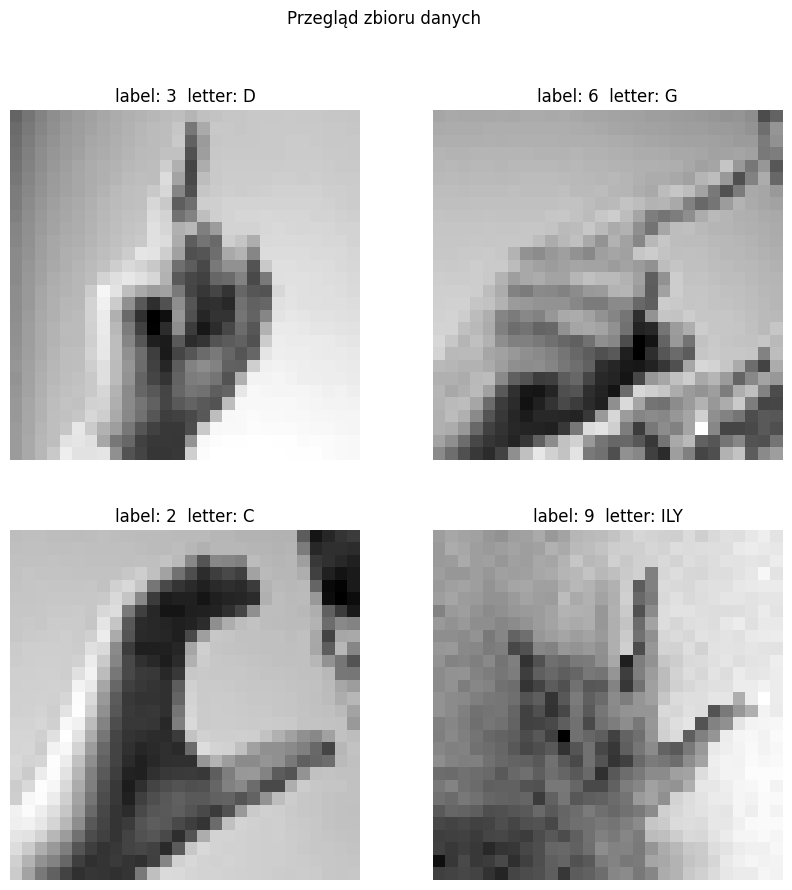

In [216]:
fig,axe=plt.subplots(2,2,figsize = (10,10))
axe[0,0].imshow(X_train[0].reshape(28,28),cmap='gray')
axe[0,0].set_title('label: 3  letter: D')
axe[0,0].axis('off')
axe[0,1].imshow(X_train[1].reshape(28,28),cmap='gray')
axe[0,1].set_title('label: 6  letter: G')
axe[0,1].axis('off')
axe[1,0].imshow(X_train[2].reshape(28,28),cmap='gray')
axe[1,0].set_title('label: 2  letter: C')
axe[1,0].axis('off')
axe[1,1].imshow(X_train[27462].reshape(28,28),cmap='gray')
axe[1,1].set_title('label: 9  letter: ILY')
axe[1,1].axis('off')
fig.suptitle('Przegląd zbioru danych', fontsize=12);

Powyższe obrazki przedstawiają rzeczywisty wygląd danych, jakie będą wykorzystywały przygotowane modele sieci neuronowych. Można zaobserwować, że zdjęcia zapisane w zbiorze MNIST zostały poddane pewnemu preprocessingowi. Nie widać na nich szumów, tło jest jednolite, a obrys dłoni wyraźny pomimo niskiej rozdzielczości. Tego samego nie można powiedzieć o zdjęciu wykonanym przez nas. Zmniejszenie rozdzielczości spowodowało, że obraz stał się zaszumiony. Dłoń pozostała widoczna, jednak jej obrys mocno zlewa się z nierównomiernym tłem.

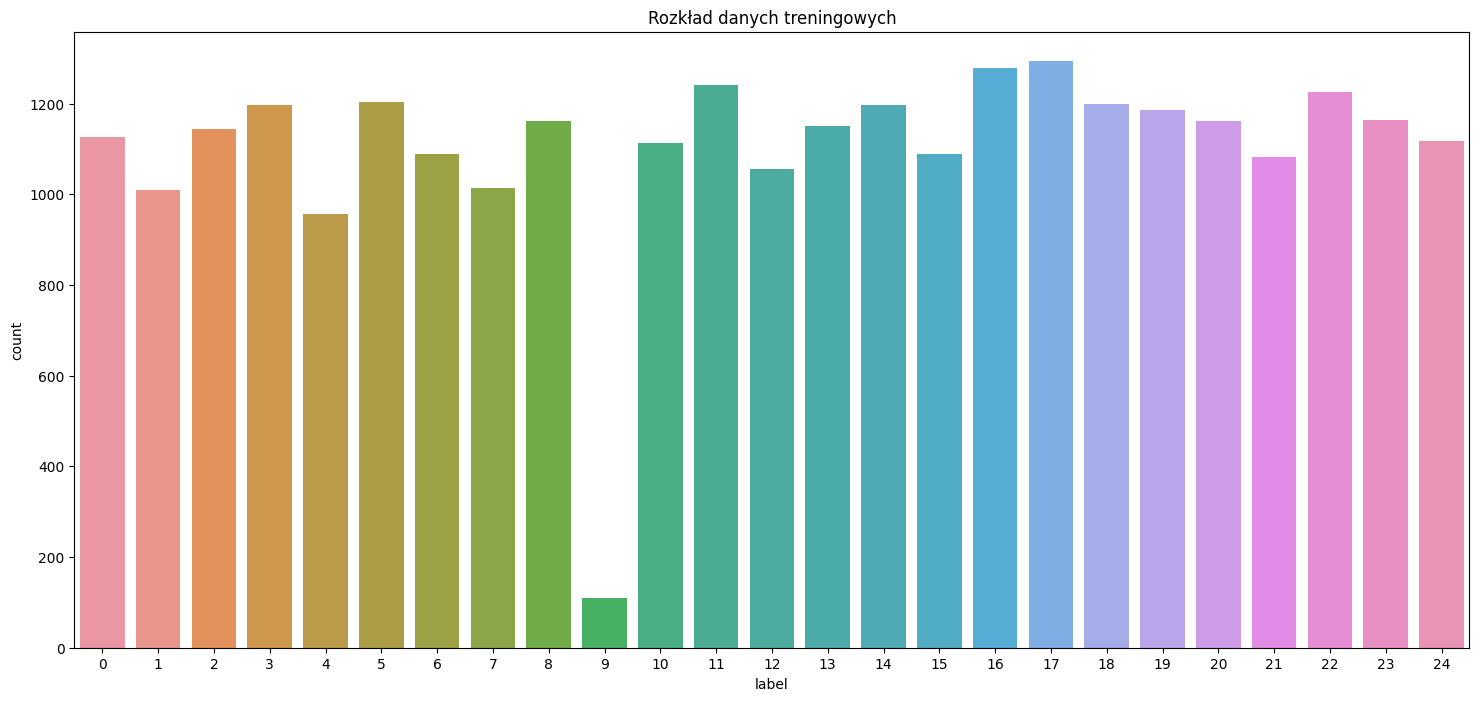

In [190]:
plt.figure(figsize = (18,8))
sns.countplot(x=train_label)
plt.title("Rozkład danych treningowych");

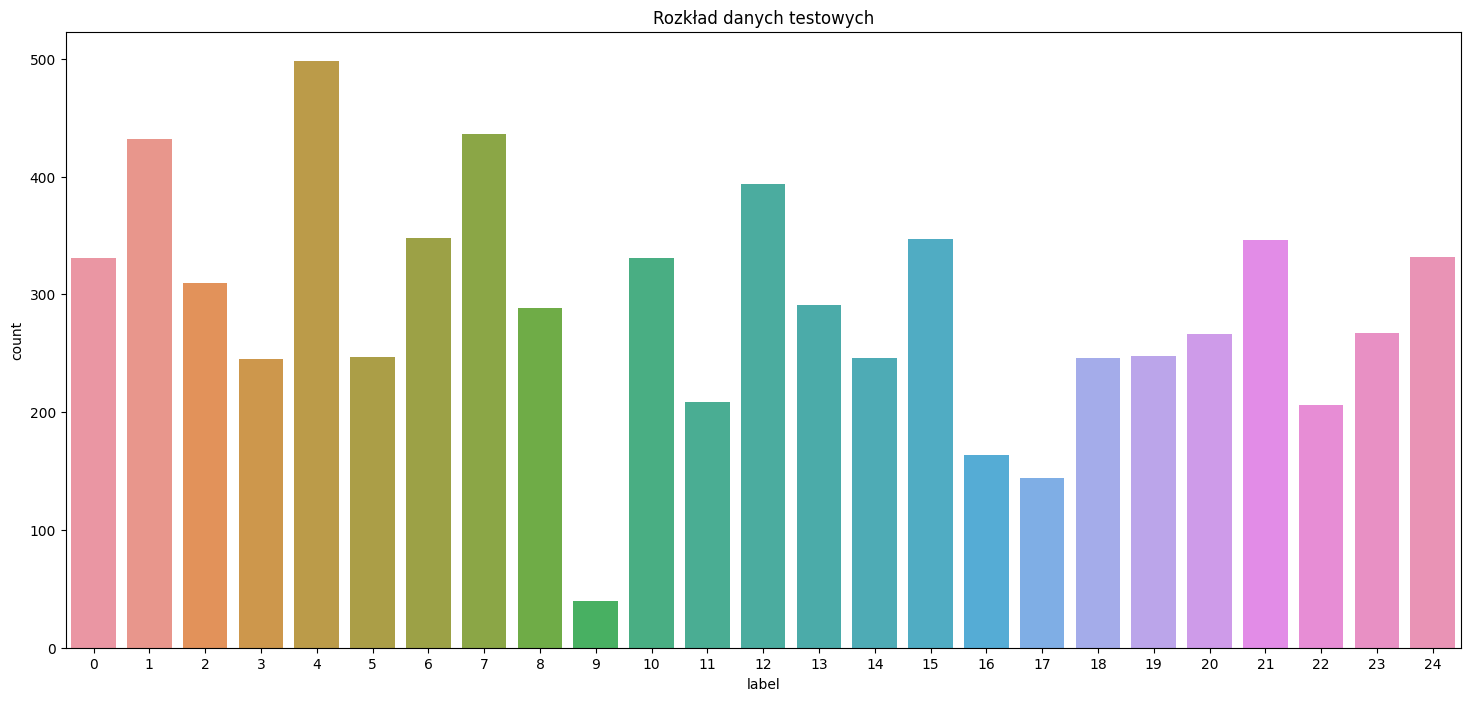

In [191]:
plt.figure(figsize = (18,8))
sns.countplot(x=test_label)
plt.title("Rozkład danych testowych");

Rozkład danych treningowych jest praktycznie równomierny, dlatego nie ma potrzeby na zastosowanie over/undersamplingu. Dane testowe nie są już tak idealne, jednak nie wpływają one w żadnym stopniu na proces uczenia. Klasa 9 jest zdecydowanie najmniej liczna, gdyż reprezentuje ona nasz własny znak. Wyrównanie histogramu wymagałoby w tym przypadku znacznie większego nakładu czasu poświeconego na przygotowanie zdjęć.

### 6. Stworzenie pierwszego modelu jednokierunkowej sieci neuronowej

Etap przygotowania modelu szucznej inteligencji rozpocznie się od stworzenia najprostszej jednokierunkowej sieci neuronowej. Jej celem jest wyznaczenie pewnego punktu odniesienia, dzięki któremu będzie można porównać uczenie płytkie z głębokim.
Przygotowana sieć składa się z:
- warstwy wejściowej - 784 neurony
- warstwy ukrytej - 256 neuronów
- warstwy wyjściowej - 25 neuronów

In [192]:
model = Sequential()
model.add(Flatten())
model.add(Dense(units=256,activation='relu'))
model.add(Dense(units=25,activation='softmax'))

In [193]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [194]:
history = model.fit(X_train,y_train,batch_size=64, verbose=0,
                    epochs = 10, validation_data=(X_test, y_test))

model.save("ANN_Model.h5")

In [195]:
model = tf.keras.models.load_model("ANN_Model.h5")

In [196]:
(ls,acc)=model.evaluate(x=X_test,y=y_test)

226/226 [==============================] - 1s 2ms/step - loss: 2.8713 - accuracy: 0.0793


In [197]:
print('Skuteczność modelu na zbiorze testowym = {:.2f}%'.format(acc*100))

Skuteczność modelu na zbiorze testowym = 7.93%


Skuteczność sieci jednokiernkowej bez ekstrakcji cech wykonanej przez wartsty konwolucyjne okazała się znikoma. Sieć nie jest w stanie nauczyć się przygotowanego zbioru nawet w najmniejszym stopniu i jest nieznacznie lepsza od zgadywania (Szansa na losowe zganięcie poprawnej odpowiedzi przy 25 klasach wynosi 4%). 

### 7. Stworzenie modelu konwolucyjnej sieci neuronowej

Wykorzystany model sieci konwolucyjnej będzie składał się z trzech warstw splotu oraz dwóch warst poolingu.
Początkowy obrazek o wymiarze 28x28 przechodzi następującą transformację:
- 32 filtry 28x28 (okno 3x3)
- MaxPooling zmniejszający rozmiar dwukrotnie (okno 2x2)
- 64 filtry 14x14 (okno 3x3)
- MaxPooling zmniejszający rozmiar dwukrotnie (okno 2x2)
- 64 filtry 7x7 (okno 3x3)

W trakcie splotu nie tracimy krawędzi zdjęcia dzięki zastosowaniu paddingu. Po wymnożeniu otrzymujemy 3136 neurony na wejściu do sieci jednokierunkowej.
Przed warstwą wyjściową składającą się z 25 neuronów (odpowiadającym liczbie klas), dodaliśmy jedną warstwę ukrytą o rozmiarze 256 neuronów. Dodatkowo losowo dezaktywujemy 1/4 neuronów w trakcie uczenia, w celu zapobegnięcia overfittingu.

In [198]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
model.add(MaxPool2D((2, 2), padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2), padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Flatten())
model.add(Dense(units=256,activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=25,activation='softmax'))

In [199]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [200]:
history_cnn = model.fit(X_train,y_train,batch_size=64, verbose=0,
                        epochs = 10, validation_data=(X_test, y_test))

model.save("CNN_Model.h5")

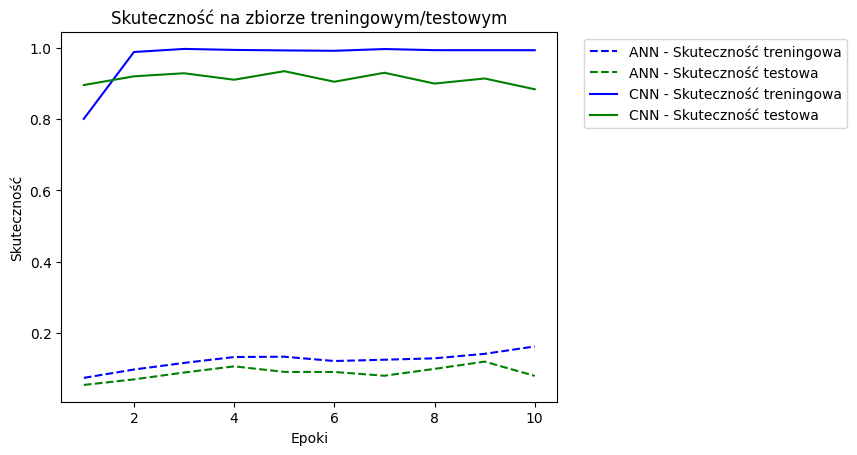

In [201]:
epochs = range(1,11)
plt.plot(epochs, history.history['accuracy'], 'b', linestyle='dashed', label='ANN - Skuteczność treningowa')
plt.plot(epochs, history.history['val_accuracy'], 'g', linestyle='dashed', label='ANN - Skuteczność testowa')
plt.plot(epochs, history_cnn.history['accuracy'], 'b', label='CNN - Skuteczność treningowa')
plt.plot(epochs, history_cnn.history['val_accuracy'], 'g', label='CNN - Skuteczność testowa')
plt.title('Skuteczność na zbiorze treningowym/testowym')
plt.xlabel('Epoki')
plt.ylabel('Skuteczność')
plt.legend(bbox_to_anchor=(1.04, 1))
plt.show()

In [202]:
model = tf.keras.models.load_model("CNN_Model.h5")

In [203]:
(ls,acc)=model.evaluate(x=X_test,y=y_test)

226/226 [==============================] - 1s 6ms/step - loss: 0.7174 - accuracy: 0.8841


In [204]:
print('Skuteczność modelu na zbiorze testowym = {:.2f}%'.format(acc*100))

Skuteczność modelu na zbiorze testowym = 88.41%


Jak możemy zauważyć sieć bardzo szybko uczy się trafnie rozpoznawać obrazy treningowe. Już po trzecim przejściu przez zbiór uzyskujemy skuteczność przekaczającą 99%. Niestety skuteczność na zbiorze testowym osiąga niewiele ponad 88%. Oznacza to, że pomimo zastosowania dropoutu sieć ulega przeuczuniu. 

Podczas realizacji projektu sprawdziliśmy wiele różnych architerktur sieci konwulucyjnych. Zmiany ilości filtrów, poolingu, rozmiarów ich okien czy też większego dropoutu za każdym razem kończyły się wynikiem z zakresu 80-90%. Sposobu na zwiększenie skuteczności modelu należy zatem szukać w ewentualnych modyfikacjach zbioru danych.

### 8. Modyfikacja zbioru danych
Pakiet ImageDataGenerator z pakietu keras.preprocessing.image umożliwia dodawanie różnych zniekształceń do zbioru obrazów poprzez zapewnienie losowego obracania, powiększania/pomniejszania, skalowania wysokości lub szerokości itp.
Zestaw danych obrazu jest tutaj również znormalizowany przy użyciu parametru rescale, który dzieli każdy piksel przez 255, tak że wartości pikseli mieszczą się w zakresie od 0 do 1.

Dodatkowo dane testowe są także są normalizowane jednak nie zastowaliśmy na nich operacji rozszerzania zbioru.

In [205]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 0,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2,
                                  shear_range=0,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

X_test=X_test/255

In [65]:
dir_It = train_datagen.flow_from_directory(
    "Example/",
    batch_size=1,
    save_to_dir="Example/Output/old/",
    save_prefix="",
    save_format='jpg',
)

for _ in range(3):
    img, label = dir_It.next()

Found 7 images belonging to 2 classes.


In [206]:
def load_images_from_folder(folder):
    examples = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is not None:
            examples.append(img)
    return examples

examples = load_images_from_folder("Example/Output/")
org_example = cv2.imread("Example/ILY/ILY_example.jpg")
org_example = cv2.cvtColor(org_example, cv2.COLOR_BGR2RGB)

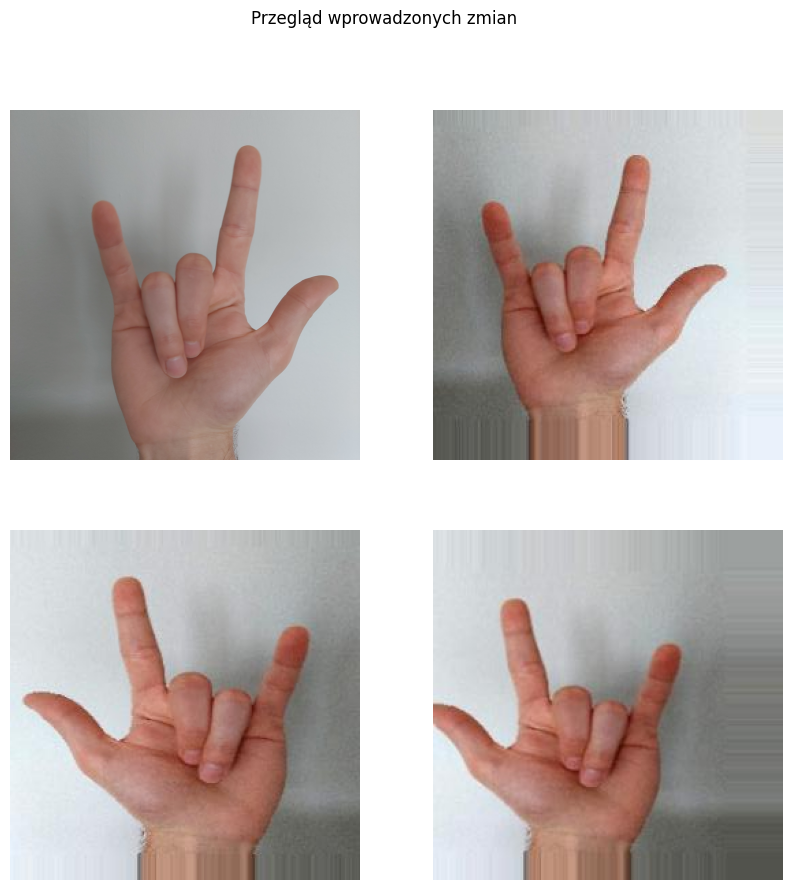

In [215]:
fig,axe=plt.subplots(2,2,figsize = (10,10))
axe[0,0].imshow(org_example,cmap='gray')
axe[0,0].axis('off')
axe[0,1].imshow(examples[0],cmap='gray')
axe[0,1].axis('off')
axe[1,0].imshow(examples[1],cmap='gray')
axe[1,0].axis('off')
axe[1,1].imshow(examples[2],cmap='gray')
axe[1,1].axis('off')
fig.suptitle('Przegląd wprowadzonych zmian', fontsize=12);

Wpowadzone zmiany spowodowały, że każde zdjęcie treningowe będzie jednorazowo zniekształcone przed podaniem go na wejście sieci. Należy zauważyć, że rozmiar zbioru danych nie jest w żaden sposób powiększany. 

Na powyższym wykresie przedstawione zostały przykładowe możliwości zmian wykonane przez pakiet ImageDataGenerator. Obraz w lewym górnym rogu jest oryginalnym zdjęciem wykonanym przez nas, natomiast pozostałe trzy fotografie zostały wygenerowane na jego podstawie. W zależności od przypadku, różne części pikseli są przesunięte, zdjęcia potrafią mieć nałożone lustrzane odbicie lub przybliżenie. Zmienia się również położenie dłoni.

### 9. Ponowne wytrenowanie sieci konwolucyjnej

Po wprowadzeniu zmian do zbioru treningowego przechodzimy do ponownego wytrenowania sieci na zmodyfikowanych danych. Wykorzystujemy identycznie przygotowany model konwolucyjny jak w poprzednim etapie.

In [153]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
model.add(MaxPool2D((2, 2), padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2), padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Flatten())
model.add(Dense(units=256,activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=25,activation='softmax'))

In [154]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(train_datagen.flow(X_train,y_train,batch_size=64), verbose=0,
         epochs = 40, validation_data=(X_test, y_test))

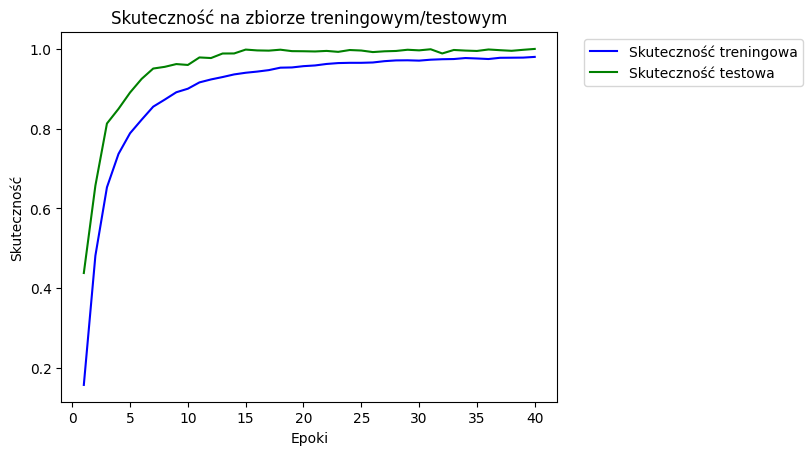

In [156]:
acc_train = history.history['accuracy']
acc_test = history.history['val_accuracy']
epochs = range(1,41)
plt.plot(epochs, acc_train, 'b', label='Skuteczność treningowa')
plt.plot(epochs, acc_test, 'g', label='Skuteczność testowa')
plt.title('Skuteczność na zbiorze treningowym/testowym')
plt.xlabel('Epoki')
plt.ylabel('Skuteczność')
plt.legend(bbox_to_anchor=(1.04, 1))
plt.show()

In [157]:
model.save("finalModel.h5")

In [158]:
model = tf.keras.models.load_model("finalModel.h5")

In [159]:
(ls,acc)=model.evaluate(x=X_test,y=y_test)

226/226 [==============================] - 1s 6ms/step - loss: 0.0022 - accuracy: 0.9997


In [160]:
print('Skuteczność modelu na zbiorze testowym = {:.2f}%'.format(acc*100))

Skuteczność modelu na zbiorze testowym = 99.97%


Zastoswane zmiany zbioru treningowego okazały się rozwiązaniem idealnym. Skuteczność na zbiorze treningowym jest minimalnie niższa, a proces uczenia znacznie się wydłużył. Nie mamy jednak doczynienia z overfittingiem, gdyż sieć osiągnęła niemal 100% skuteczności na zbiorze testowym.

#### Sprawdzenie skuteczności na dodatkowym znaku "I love you"

In [161]:
ily_X_test = X_test[-40:]
ily_y_test = y_test[-40:]

print(ily_X_test.shape, ily_y_test.shape)

(40, 28, 28, 1) (40, 25)


In [162]:
(ls,acc)=model.evaluate(x=ily_X_test,y=ily_y_test)

2/2 [==============================] - 0s 4ms/step - loss: 1.0609e-05 - accuracy: 1.0000


In [163]:
print('Skuteczność modelu na znaku ILY = {:.2f}%'.format(acc*100))

Skuteczność modelu na znaku ILY = 100.00%


Dodatkowo sprawdziliśmy skuteczność sieci jedynie na obrazach dodanych przez nas. Model poprawnie sklasyfikował wszystkie z 40 testowych zdjęć symbolu "I Love You".

### 10. Rozpoznawania symboli z obrazu kamery

In [2]:
import cv2
import numpy as np
import tensorflow as tf
from keras import models

In [3]:
def getLetter(result):
    classLabels = { 0: 'A',
                    1: 'B',
                    2: 'C',
                    3: 'D',
                    4: 'E',
                    5: 'F',
                    6: 'G',
                    7: 'H',
                    8: 'I',
                    9: 'ILY',
                    10: 'K',
                    11: 'L',
                    12: 'M',
                    13: 'N',
                    14: 'O',
                    15: 'P',
                    16: 'Q',
                    17: 'R',
                    18: 'S',
                    19: 'T',
                    20: 'U',
                    21: 'V',
                    22: 'W',
                    23: 'X',
                    24: 'Y',}
    try:
        res = int(result)
        return classLabels[res]
    except:
        return "Error"



In [4]:
def keras_predict(model, image):
    pred_probab = model.predict(image)[0]
    pred_class = list(pred_probab).index(max(pred_probab))
    return max(pred_probab), pred_class

In [10]:
# cap = cv2.VideoCapture(0) ## Kamera laptopa
cap = cv2.VideoCapture(2)   ## Kamera zewnętrzna

model = models.load_model('finalModel.h5')


while True:

    ret, frame = cap.read()
    
    ##############################
    frame=cv2.flip(frame, 1)

    #define region of interest
    roi = frame[100:400, 320:620]
    #cv2.imshow('roi', roi)
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    roi = cv2.resize(roi, (28, 28), interpolation = cv2.INTER_AREA)
    
    cv2.imshow('roi scaled and gray', roi)
    copy = frame.copy()
    cv2.rectangle(copy, (320, 100), (620, 400), (255,0,0), 5)
    
    roi = roi.reshape(1,28,28,1) 
    roi = roi/255
    pred_probab, pred_class = keras_predict(model,roi)
     
    # print(pred_probab*100)
    # print(X_train[np.argmax(Y_proba)])
        
    #wynik = np.argmax(Y_proba)
    litera = getLetter(pred_class)
    cv2.putText(copy, litera, (300 , 100), cv2.FONT_HERSHEY_COMPLEX, 2, (0, 255, 0), 2)
    cv2.imshow('frame', copy)    
    
    if cv2.waitKey(1) == 13: #13 odpowiada za enter
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 34ms/step


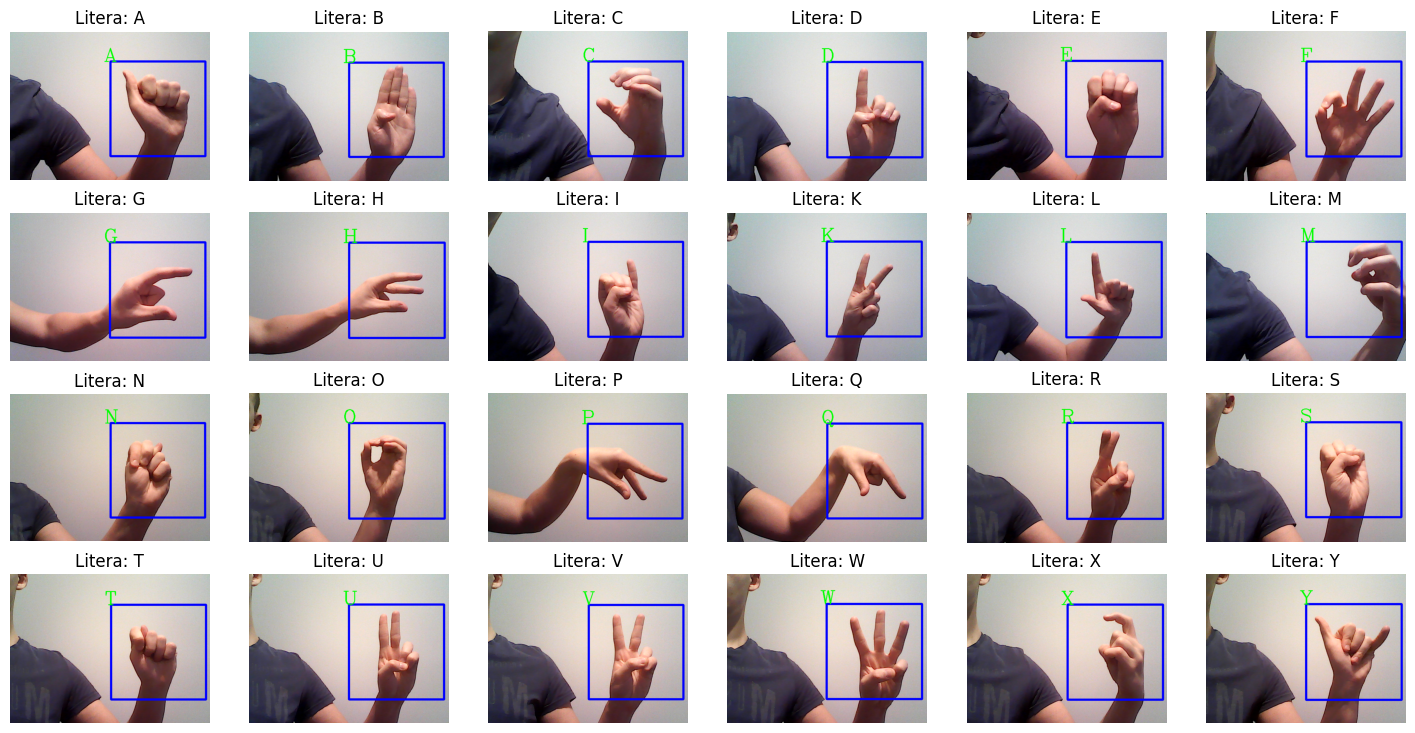

In [81]:
results = load_images_from_folder("Results/")

fig,axe=plt.subplots(4,6,figsize = (18,9))
axe[0,0].imshow(results[0], cmap='gray')
axe[0,0].set_title('Litera: A')
axe[0,0].axis('off')
axe[0,1].imshow(results[1], cmap='gray')
axe[0,1].set_title('Litera: B')
axe[0,1].axis('off')
axe[0,2].imshow(results[2], cmap='gray')
axe[0,2].set_title('Litera: C')
axe[0,2].axis('off')
axe[0,3].imshow(results[3], cmap='gray')
axe[0,3].set_title('Litera: D')
axe[0,3].axis('off')
axe[0,4].imshow(results[4], cmap='gray')
axe[0,4].set_title('Litera: E')
axe[0,4].axis('off')
axe[0,5].imshow(results[5], cmap='gray')
axe[0,5].set_title('Litera: F')
axe[0,5].axis('off')
axe[1,0].imshow(results[6], cmap='gray')
axe[1,0].set_title('Litera: G')
axe[1,0].axis('off')
axe[1,1].imshow(results[7], cmap='gray')
axe[1,1].set_title('Litera: H')
axe[1,1].axis('off')
axe[1,2].imshow(results[8], cmap='gray')
axe[1,2].set_title('Litera: I')
axe[1,2].axis('off')
axe[1,3].imshow(results[9], cmap='gray')
axe[1,3].set_title('Litera: K')
axe[1,3].axis('off')
axe[1,4].imshow(results[10], cmap='gray')
axe[1,4].set_title('Litera: L')
axe[1,4].axis('off')
axe[1,5].imshow(results[11], cmap='gray')
axe[1,5].set_title('Litera: M')
axe[1,5].axis('off')
axe[2,0].imshow(results[12], cmap='gray')
axe[2,0].set_title('Litera: N')
axe[2,0].axis('off')
axe[2,1].imshow(results[13], cmap='gray')
axe[2,1].set_title('Litera: O')
axe[2,1].axis('off')
axe[2,2].imshow(results[14], cmap='gray')
axe[2,2].set_title('Litera: P')
axe[2,2].axis('off')
axe[2,3].imshow(results[15], cmap='gray')
axe[2,3].set_title('Litera: Q')
axe[2,3].axis('off')
axe[2,4].imshow(results[16], cmap='gray')
axe[2,4].set_title('Litera: R')
axe[2,4].axis('off')
axe[2,5].imshow(results[17], cmap='gray')
axe[2,5].set_title('Litera: S')
axe[2,5].axis('off')
axe[3,0].imshow(results[18], cmap='gray')
axe[3,0].set_title('Litera: T')
axe[3,0].axis('off')
axe[3,1].imshow(results[19], cmap='gray')
axe[3,1].set_title('Litera: U')
axe[3,1].axis('off')
axe[3,2].imshow(results[20], cmap='gray')
axe[3,2].set_title('Litera: V')
axe[3,2].axis('off')
axe[3,3].imshow(results[21], cmap='gray')
axe[3,3].set_title('Litera: W')
axe[3,3].axis('off')
axe[3,4].imshow(results[22], cmap='gray')
axe[3,4].set_title('Litera: X')
axe[3,4].axis('off')
axe[3,5].imshow(results[23], cmap='gray')
axe[3,5].set_title('Litera: Y')
axe[3,5].axis('off')

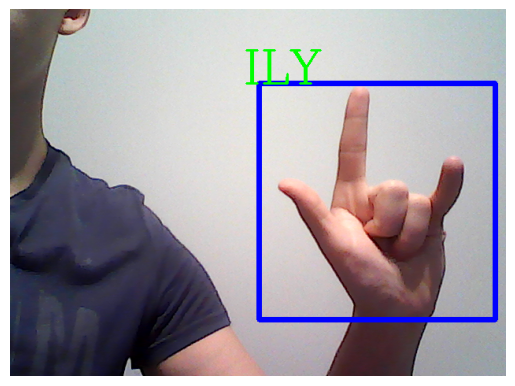

In [82]:
plt.figure()
ily_example = cv2.imread("Example/ILY/ILY_RESULT.png")
ily_example = cv2.cvtColor(ily_example, cv2.COLOR_BGR2RGB)
plt.imshow(ily_example, cmap='gray')
plt.axis('off')